In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
params={     
    'axes.labelsize'  : '14',   
    'axes.titlesize'  : '14',  
    'xtick.labelsize' :'14',
    'ytick.labelsize' :'14',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '10', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [3]:
## IMERG
satellite_path = "/g/data/k10/cb4968/metrics/observations/IMERG/small_domain/pr_based/IMERG/pr_based_IMERG_3hrly_0-360_-30-30_3600x1800_2001-01_2023-12_boxsize_5/"
sat_files = sorted(glob(f"{satellite_path}pr_based_IMERG_3hrly_*.nc"))
ds_sat = xr.open_mfdataset(sat_files,chunks={"time":10})
# ERA5
ds_tcwv = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/tcwv/*.nc")))
ds_max_cape = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/max_cape/*.nc")))
ds_cape = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/cape/*.nc")))

## land sea mask
ds_lsm = xr.open_dataset("/g/data/k10/cr7888/era5_daily_means_5deg/lsm_5deg.nc") 

In [4]:
lsm = ds_lsm["lsm"]
# prcp intensity at rain cell
cell_pr = ds_sat["pr_based_mean_pr"]/ds_sat["pr_based_area_fraction"]
# mean precipitation
mean_pr = ds_sat["pr_based_mean_pr"].resample(time='1D').mean().where(lsm == 0)
# Iorg
iorg= ds_sat["pr_based_Iorg"].resample(time='1D').mean().where(lsm == 0)
## make ERA5 data timestamps to match IMERG data
ds_tcwv["time"] = ds_tcwv["time"].dt.floor("D")
ds_max_cape["time"] = ds_max_cape["time"].dt.floor("D")
ds_cape["time"] = ds_cape["time"].dt.floor("D")


In [5]:
%%time
## ERA5 environmental conditions
tcwv = ds_tcwv["tcwv"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()
# max CAPE
max_cape = ds_max_cape["cape"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()
cape = ds_cape["cape"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()

## IMERG daily
mean_pr_match = mean_pr.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()
iorg_match = iorg.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()
cell_pr_match = cell_pr.resample(time='1D').mean().where(lsm == 0).sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()                           

CPU times: user 2min 38s, sys: 17.8 s, total: 2min 56s
Wall time: 2min 31s


Text(0, 0.5, 'Total column water vapour (kg m$^{-2}$)')

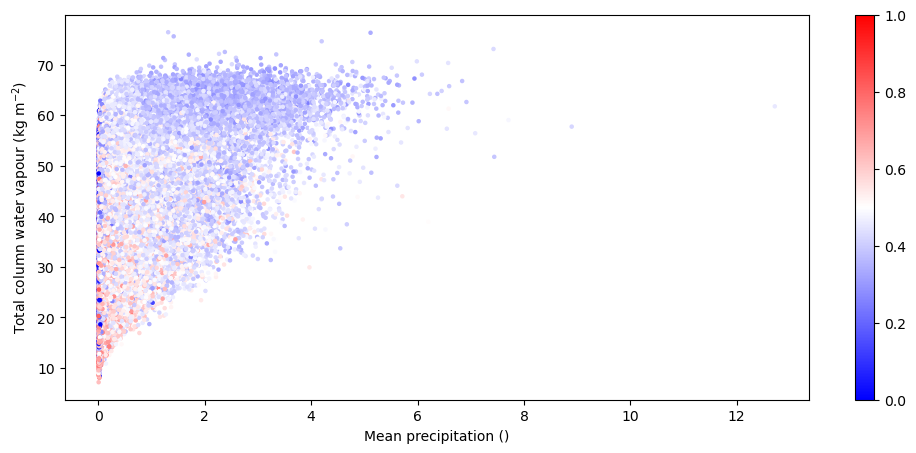

In [5]:
plt.figure(figsize=(12,5))
plt.scatter(mean_pr_match.values.flatten(), tcwv.values.flatten(), s=5,
            c=iorg_match.values.flatten(), vmin=0, vmax=1, cmap="bwr")
plt.colorbar()
plt.xlabel("Mean precipitation ()")
plt.ylabel("Total column water vapour (kg m$^{-2}$)")

In [6]:
def bin_data(x, y, num_bins= 10, bin_min = 0.5, bin_max=8.5):
    '''
    The bins are for mean precipitation in this case, so I won't change them.
    '''

    # Remove NaNs (important if data has missing values)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    # Define bins for x (mean_pr)
    # num_bins = 10  # or choose based on your data
    bins = np.linspace(bin_min, bin_max, num_bins + 1)
    
    # Compute bin centers for plotting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Digitize x to get which bin each value falls into
    bin_idx = np.digitize(x, bins)
    
    # Compute mean y (tcwv) for each bin
    # Compute binned means and counts
    bin_means = [np.nanmean(y[bin_idx == i]) if np.any(bin_idx == i) else np.nan for i in range(1, len(bins))]
    bin_counts = [np.nansum(bin_idx == i) for i in range(1, len(bins))]
    return bin_centers, bin_means, bin_counts

In [25]:
## convert data to 1D for plotting
mean_pr_1D = mean_pr_match.values.flatten()
tcwv_1D = tcwv.values.flatten()
iorg_1D = iorg_match.values.flatten()
cell_pr_1D = cell_pr_match.values.flatten()
mean_cape_1D = cape.values.flatten()

max_cape_1D =  max_cape.values.flatten()

#### TCWV
## All data bins
all_bin_centers, all_bin_means, all_bin_counts = bin_data(mean_pr_1D, tcwv_1D)

## low organization and high organization
low_org_bin_centers, low_org_bin_means, low_org_bin_counts = bin_data(mean_pr_1D[iorg_1D<0.3], tcwv_1D[iorg_1D<0.3])
high_org_bin_centers, high_org_bin_means, high_org_bin_counts = bin_data(mean_pr_1D[iorg_1D>=0.5], tcwv_1D[iorg_1D>=0.5])

# Try to filter high and low intensity based on percentiles
p20_intensity = np.nanpercentile(cell_pr_1D,50)
p80_intensity = np.nanpercentile(cell_pr_1D,80)

low_pr_bin_centers, low_pr_bin_means, low_pr_bin_counts = bin_data(mean_pr_1D[cell_pr_1D<p20_intensity], tcwv_1D[cell_pr_1D<p20_intensity])
high_pr_bin_centers, high_pr_bin_means, high_pr_bin_counts = bin_data(mean_pr_1D[cell_pr_1D>p80_intensity], tcwv_1D[cell_pr_1D>p80_intensity])

#### MEAN CAPE
## All data bins
all_bin_centers_cape, all_bin_means_cape, all_bin_counts_cape = bin_data(mean_pr_1D, mean_cape_1D)

## low organization and high organization
low_org_bin_centers_cape, low_org_bin_means_cape, low_org_bin_counts_cape = bin_data(mean_pr_1D[iorg_1D<0.3], mean_cape_1D[iorg_1D<0.3])
high_org_bin_centers_cape, high_org_bin_means_cape, high_org_bin_counts_cape = bin_data(mean_pr_1D[iorg_1D>0.5], mean_cape_1D[iorg_1D>0.5])

## low intensity and high intensity
low_pr_bin_centers_cape, low_pr_bin_means_cape, low_pr_bin_counts_cape = bin_data(mean_pr_1D[cell_pr_1D<p20_intensity], mean_cape_1D[cell_pr_1D<p20_intensity])
high_pr_bin_centers_cape, high_pr_bin_means_cape, high_pr_bin_counts_cape = bin_data(mean_pr_1D[cell_pr_1D>p80_intensity], mean_cape_1D[cell_pr_1D>p80_intensity])

#### MAX CAPE
## All data bins
all_bin_centers_mcape, all_bin_means_mcape, all_bin_counts_mcape = bin_data(mean_pr_1D, max_cape_1D)

## low organization and high organization
low_org_bin_centers_mcape, low_org_bin_means_mcape, low_org_bin_counts_mcape = bin_data(mean_pr_1D[iorg_1D<0.3], max_cape_1D[iorg_1D<0.3])
high_org_bin_centers_mcape, high_org_bin_means_mcape, high_org_bin_counts_mcape = bin_data(mean_pr_1D[iorg_1D>0.5], max_cape_1D[iorg_1D>0.5])

## low intensity and high intensity
low_pr_bin_centers_mcape, low_pr_bin_means_mcape, low_pr_bin_counts_mcape = bin_data(mean_pr_1D[cell_pr_1D<p20_intensity], max_cape_1D[cell_pr_1D<p20_intensity])
high_pr_bin_centers_mcape, high_pr_bin_means_mcape, high_pr_bin_counts_mcape = bin_data(mean_pr_1D[cell_pr_1D>p80_intensity], max_cape_1D[cell_pr_1D>p80_intensity])


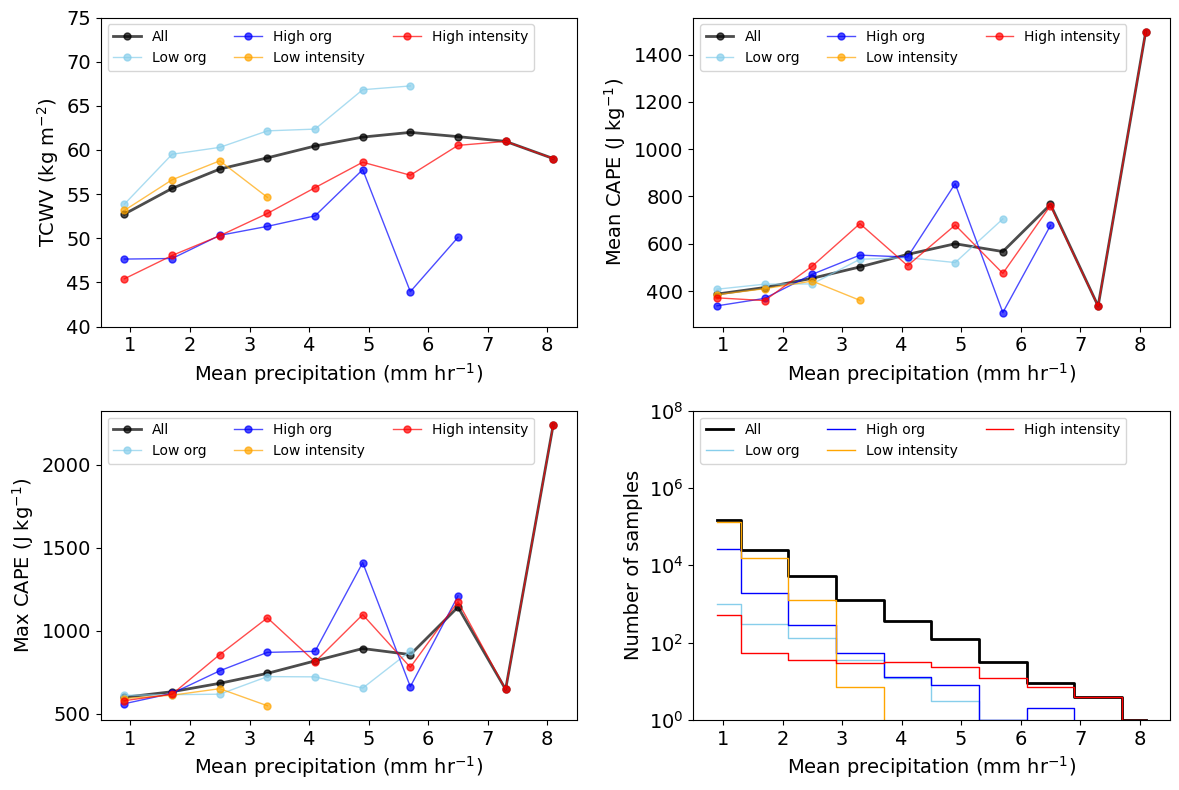

In [26]:

# Create figure and axes
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(221)
# Plot scatter and binned mean
# ax1.scatter(x, y, alpha=0.2, label='Raw data')
ax1.plot(all_bin_centers, all_bin_means, color='k', 
         marker='o', markersize=5,linewidth=2,label='All',alpha=0.7)

ax1.plot(low_org_bin_centers, low_org_bin_means, color='skyblue',
         marker='o', markersize=5,linewidth=1,label='Low org',alpha=0.7)
ax1.plot(high_org_bin_centers, high_org_bin_means, color='blue',
         marker='o', markersize=5,linewidth=1,label='High org',alpha=0.7)

ax1.plot(low_pr_bin_centers, low_pr_bin_means, color='orange',
         marker='o', markersize=5,linewidth=1,label='Low intensity',alpha=0.7)
ax1.plot(high_pr_bin_centers, high_pr_bin_means, color='red',
         marker='o', markersize=5,linewidth=1,label='High intensity',alpha=0.7)

ax1.set_xlabel('Mean precipitation (mm hr$^{-1}$)')
ax1.set_ylabel('TCWV (kg m$^{-2}$)')
ax1.legend(loc='upper left')
ax1.set_xlim([0.5, 8.5])
ax1.set_ylim([40,75])
lines, labels = ax1.get_legend_handles_labels()

ax1.legend(lines , labels , loc='upper left',ncol=3)
# Add second y-axis for bin counts
ax2= fig.add_subplot(222)

ax2.plot(all_bin_centers_cape, all_bin_means_cape, color='k', 
         marker='o', markersize=5,linewidth=2,label='All',alpha=0.7)

ax2.plot(low_org_bin_centers_cape, low_org_bin_means_cape, color='skyblue', 
         marker='o', markersize=5, linewidth=1,label='Low org',alpha=0.7)
ax2.plot(high_org_bin_centers_cape, high_org_bin_means_cape, color='blue', 
         marker='o', markersize=5, linewidth=1,label='High org',alpha=0.7)

ax2.plot(low_pr_bin_centers_cape, low_pr_bin_means_cape, color='orange', 
         marker='o', markersize=5, linewidth=1,label='Low intensity',alpha=0.7)
ax2.plot(high_pr_bin_centers_cape, high_pr_bin_means_cape, color='red',
         marker='o', markersize=5, linewidth=1,label='High intensity',alpha=0.7)

ax2.set_xlabel('Mean precipitation (mm hr$^{-1}$)')
ax2.set_ylabel('Mean CAPE (J kg$^{-1}$)')
ax2.legend(loc='upper left')
ax2.set_xlim([0.5, 8.5])
# ax3.set_ylim([40,75])
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines2, labels2, loc='upper left',ncol=3)




ax3= fig.add_subplot(223)
# Plot scatter and binned mean

ax3.plot(all_bin_centers_mcape, all_bin_means_mcape, color='k', 
         marker='o', markersize=5,linewidth=2,label='All',alpha=0.7)

ax3.plot(low_org_bin_centers_mcape, low_org_bin_means_mcape, color='skyblue', 
         marker='o', markersize=5, linewidth=1,label='Low org',alpha=0.7)
ax3.plot(high_org_bin_centers_mcape, high_org_bin_means_mcape, color='blue', 
         marker='o', markersize=5, linewidth=1,label='High org',alpha=0.7)

ax3.plot(low_pr_bin_centers_mcape, low_pr_bin_means_mcape, color='orange', 
         marker='o', markersize=5, linewidth=1,label='Low intensity',alpha=0.7)
ax3.plot(high_pr_bin_centers_mcape, high_pr_bin_means_mcape, color='red',
         marker='o', markersize=5, linewidth=1,label='High intensity',alpha=0.7)

ax3.set_xlabel('Mean precipitation (mm hr$^{-1}$)')
ax3.set_ylabel('Max CAPE (J kg$^{-1}$)')
ax3.legend(loc='upper left')
ax3.set_xlim([0.5, 8.5])
# ax3.set_ylim([40,75])
lines3, labels3 = ax3.get_legend_handles_labels()

ax3.legend(lines3 , labels3 , loc='upper left',ncol=3)
# Add second y-axis for bin counts
ax4= fig.add_subplot(224)

ax4.step(all_bin_centers_cape, all_bin_counts_cape, where='mid', color='k', linewidth=2, label='All')
ax4.step(low_org_bin_centers_cape, low_org_bin_counts_cape, where='mid', color='skyblue', linewidth=1, label='Low org')
ax4.step(high_org_bin_centers_cape, high_org_bin_counts_cape, where='mid', color='blue', linewidth=1, label='High org')

ax4.step(low_pr_bin_centers_cape, low_pr_bin_counts_cape, where='mid', color='orange', linewidth=1, label='Low intensity')
ax4.step(high_pr_bin_centers_cape, high_pr_bin_counts_cape, where='mid', color='red', linewidth=1, label='High intensity')
ax4.set_xlabel('Mean precipitation (mm hr$^{-1}$)')
ax4.set_ylabel('Number of samples')
ax4.set_yscale('log')
ax4.set_xlim([0.5, 8.5])
# Optional: add legend for second axis
lines4, labels4 = ax4.get_legend_handles_labels()
ax4.legend(lines4 , labels4 , loc='upper left',ncol=3)



ax4.set_ylim([1,10**8])


plt.tight_layout()
plt.savefig("/home/565/dl6968/meso-org/Figures/Fig2.png", dpi=200, bbox_inches="tight")
plt.show()
